# Gradient Boosting Machines

Gradient Boosting Machines (GBM) are ensembles of _sequentially_ trained shallow decision trees. The basic premise is that of **boosting**, that is an ensemble of simple classifiers can perform better than a complex classifier. The next tree utilised the current error of the ensemble to better the performance of the model. It is named **gradient** boosting since it utilises gradient descent to minimize the error of the ensemble.

The gif below illustrates the learning of the GBM in a regression setting. [More info here.](http://uc-r.github.io/gbm_regression) In the beginning the errors are large. With each iteration, the next tree tunes the predictions where the ensemble still lacks in performance.

<img src="./misc/Gradient_Boosting_Machine_Viz.gif" width="400" align="center"/>

Advantages of the gradient boosting machines are
* Modern libraries, e.g. `lightgbm` allow the user to calculate feature importance for the different features. See the documentation for the libraries for the methods of calculation of features importance.
* Abundance of parameters that can be tuned in order to optimse the fit to your sample.

Whereas disadvantages include,
* Risk of overfitting, since the model is trying to minimize even the smallest error. Risk can be alleviated by regularization. [1]
* Slow considering that we need many weak learners to achieve high performance of the ensemble model. [1]

In this notebook, we utilise Microsoft's implementation of GBM: `lightgbm`.

## Comment on parameters

As stated above, there is an abundace of parameters to tune. 

For `lightgbm`, some parameters to tune in order to deal with overfitting include [4]

* `num_leaves`, i.e. the maximum number of leaves in one tree. Should be **small**
* `min_data_in_leaf`, self-explanatory. Should be **small**.
* `lambda_l1` and `lambda_l2`, regularization parameters. Hihger value means higher regularization.

The authors also state that to achieve good performance one should modify the `max_depth` parameter.

In order to decide which parameters to tune, we need to determine what we want to achieve with the tuning. This is evalauted after an intial fitting of the model.

References: 

[1] http://uc-r.github.io/gbm_regression

[2] https://sefiks.com/2020/05/13/xgboost-vs-lightgbm/

[3] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

# Preprocessing

Utilise the custom function importData to load the data. We utilise `pyarrow.feather` to read the data faster than with a csv. See the docs for more information: https://arrow.apache.org/docs/python/feather.html

In [2]:
# External
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
# Internal
import utils.nicer_plots
from utils.import_data import importData
from utils.model_tester import ModelTester
# Other notebook settings
%load_ext autoreload
%autoreload 2

The file `data2.feather` was prepared beforehand and need to be for your case as well if you want to read the data in feather format.

In [4]:
file_data = "data2.feather"  ## Note: Change to data2.csv if .csv file instead
file_labels = "labels2.csv"
n_features = -1
directory = "/data/"

data, labels = importData(file_data, file_labels, directory, n_features, iterations=False)

Number of samples:    102400
Number of features:   3851


# Model Definition - Lightgbm

In [9]:
mt = ModelTester(data, labels, LGBMClassifier, verbosity = -1)
print(mt.model(**mt.parameters))

LGBMClassifier(verbosity=-1)


Lets run an initial test to know what direction to proceed in hyper-parameter tuning.

In [10]:
mt.training_loop(sampling='under')

## Metrics on the Training Set

In [11]:
mt.print_essentials(test = False, results_path = "../models/results/lgbm")

Results: 

variable                             average    std  95.0% PI            min     max
---------------------------------  ---------  -----  ---------------  ------  ------
weighted accuracy [%]                  99.94   0.11  (99.87, 100.02)   99.66  100
duration [s]                           11.6    0.17  (11.48, 11.72)    11.37   11.89
infeasible_percentage [%]              84.63   3.12  (82.4, 86.87)     76.62   87.85
infeasible_guessed_percentage [%]      84.66   3.08  (82.45, 86.86)    76.78   87.85
feasible_recall [%]                    99.89   0.22  (99.73, 100.04)   99.32  100
feasible_precision [%]                100      0     (100.0, 100.0)   100     100
infeasible_recall [%]                 100      0     (100.0, 100.0)   100     100
infeasible_precision [%]               99.97   0.06  (99.93, 100.02)   99.79  100
auc of roc                              0      0     (0.0, 0.0)         0       0

Results saved to ../models/results/lgbm/train


## Metrics on the Test Set

In [12]:
mt.print_essentials(results_path = "../models/results/lgbm")

Results: 

variable                             average    std  95.0% PI          min     max
---------------------------------  ---------  -----  --------------  -----  ------
weighted accuracy [%]                  50.32   0.38  (50.05, 50.59)  49.82   50.98
duration [s]                           11.48   0.17  (11.36, 11.6)   11.24   11.77
infeasible_percentage [%]              82.56   2.4   (80.85, 84.28)  77.25   85.45
infeasible_guessed_percentage [%]      97.68   2.7   (95.74, 99.61)  91.41  100
feasible_recall [%]                     2.84   3.03  (0.67, 5.0)      0       9
feasible_precision [%]                 20.74  15.48  (9.67, 31.81)    0      50
infeasible_recall [%]                  97.8    2.65  (95.9, 99.69)   91.5   100
infeasible_precision [%]               82.66   2.33  (80.99, 84.33)  77.47   85.42
auc of roc                              0.47   0.01  (0.46, 0.48)     0.44    0.5

Results saved to ../models/results/lgbm/test


There is clear **overfitting** to the training data, with 99.94% in weighted accuracy. We thus want to reduce overfitting.

# Results

In order to reduce overfitting and improve performance, we utilise the information from the introduction to the notebook. The default parameters of these are given below

In [10]:
LGBMClassifier().__dict__

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.0,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'random_state': None,
 'n_jobs': -1,
 'silent': 'warn',
 'importance_type': 'split',
 '_Booster': None,
 '_evals_result': None,
 '_best_score': None,
 '_best_iteration': None,
 '_other_params': {},
 '_objective': None,
 'class_weight': None,
 '_class_weight': None,
 '_class_map': None,
 '_n_features': None,
 '_n_features_in': None,
 '_classes': None,
 '_n_classes': None}

### **Note:** Tried to suppress warnings using `verbosity=-1` but apparently a bug. Follow the issue here: https://github.com/microsoft/LightGBM/issues/4518

In [14]:
sampling = 'under'

## More info here https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
parameters = {
    'num_leaves': [10, 20, 31],
    'max_depth': [-1, 50, 500],  ## -1 refers to unlimited depth
    'lambda_l1': [0.001, 0.01, 0.1],
    'verbosity': [-1]}
# Run the hyperparameter tuning
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 5, score = "balanced_accuracy", update_parameters = True, sampling = 'under', **parameters)

  0%|                                                                         | 0/27 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001


  4%|██▍                                                              | 1/27 [00:29<12:56, 29.86s/it]

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01


  7%|████▊                                                            | 2/27 [01:00<12:35, 30.22s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


 11%|███████▏                                                         | 3/27 [01:32<12:27, 31.14s/it]

[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001


 15%|█████████▋                                                       | 4/27 [02:03<11:56, 31.13s/it]

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01


 19%|████████████                                                     | 5/27 [02:37<11:43, 31.98s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


 22%|██████████████▍                                                  | 6/27 [03:10<11:24, 32.58s/it]

[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001


 26%|████████████████▊                                                | 7/27 [03:41<10:39, 31.99s/it]

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01


 30%|███████████████████▎                                             | 8/27 [04:13<10:05, 31.88s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


 33%|█████████████████████▋                                           | 9/27 [04:45<09:38, 32.12s/it]

[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001


 37%|███████████████████████▋                                        | 10/27 [05:39<11:00, 38.86s/it]

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01


 41%|██████████████████████████                                      | 11/27 [06:34<11:40, 43.78s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


 44%|████████████████████████████▍                                   | 12/27 [07:36<12:19, 49.29s/it]

[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001


 48%|██████████████████████████████▊                                 | 13/27 [08:29<11:45, 50.41s/it]

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01


 52%|█████████████████████████████████▏                              | 14/27 [09:26<11:20, 52.33s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


 56%|███████████████████████████████████▌                            | 15/27 [10:25<10:52, 54.41s/it]

[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001


 59%|█████████████████████████████████████▉                          | 16/27 [11:21<10:01, 54.70s/it]

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01


 63%|████████████████████████████████████████▎                       | 17/27 [12:13<09:00, 54.06s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


 67%|██████████████████████████████████████████▋                     | 18/27 [13:07<08:04, 53.87s/it]

[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001


 70%|█████████████████████████████████████████████                   | 19/27 [14:20<07:58, 59.82s/it]

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01


 74%|███████████████████████████████████████████████▍                | 20/27 [15:42<07:45, 66.53s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


 78%|█████████████████████████████████████████████████▊              | 21/27 [17:03<07:04, 70.81s/it]

[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001


 81%|████████████████████████████████████████████████████▏           | 22/27 [18:20<06:03, 72.67s/it]

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01


 85%|██████████████████████████████████████████████████████▌         | 23/27 [19:39<04:57, 74.43s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


 89%|████████████████████████████████████████████████████████▉       | 24/27 [20:59<03:48, 76.18s/it]

[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001


 93%|███████████████████████████████████████████████████████████▎    | 25/27 [22:13<02:31, 75.50s/it]

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01


 96%|█████████████████████████████████████████████████████████████▋  | 26/27 [23:29<01:15, 75.67s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


100%|████████████████████████████████████████████████████████████████| 27/27 [24:47<00:00, 55.07s/it]


   Ranking    num_leaves    max_depth    lambda_l1    verbosity    balanced_accuracy    Standard deviation
---------  ------------  -----------  -----------  -----------  -------------------  --------------------
        1            31          500        0.001           -1             0.506215            0.00747652
        2            31           50        0.001           -1             0.506215            0.00747652
        3            31           -1        0.001           -1             0.506215            0.00747652
        4            20           50        0.01            -1             0.503425            0.00447985
        5            20          500        0.01            -1             0.503425            0.00447985
        6            20           -1        0.01            -1             0.503425            0.00447985
        7            31           50        0.01            -1             0.502841            0.007407
        8            31           -1        0.

{'num_leaves': 31, 'max_depth': -1, 'lambda_l1': 0.001, 'verbosity': -1}

Re run the training loop using the best hyper parameters

In [15]:
mt.parameters = {
    'num_leaves': 31, 
    'max_depth': -1, 
    'lambda_l1': 0.001, 
    'verbosity': -1
}
mt.training_loop(sampling = 'under')

[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001


And print the metrics using those parameters

In [16]:
mt.print_essentials()

Results: 

variable                             average    std  95.0% PI           min    max
---------------------------------  ---------  -----  ---------------  -----  -----
weighted accuracy [%]                  50.62   0.75  (49.69, 51.55)   49.93  51.87
duration [s]                           13.87   0.61  (13.12, 14.62)   13.25  14.99
infeasible_percentage [%]              81.47   2.67  (78.17, 84.78)   77.25  85.06
infeasible_guessed_percentage [%]      96.62   3.05  (92.83, 100.41)  91.5   99.95
feasible_recall [%]                     4.36   4.19  (-0.84, 9.57)     0     11.5
feasible_precision [%]                 18.16  11.49  (3.89, 32.42)     0     32.5
infeasible_recall [%]                  96.88   2.78  (93.42, 100.34)  92.23  99.94
infeasible_precision [%]               81.69   2.49  (78.6, 84.79)    77.64  85.04
auc of roc                              0.47   0.01  (0.45, 0.48)      0.45   0.48


We notice two major things:

* The prediction interval of the balanced accuracy contains 0.5, meaning that with 95% confidence we can say that the model did not perform better than chance.
* The percentage of points guessed as infeasible is still high, even including regularization

Lets plot these results as well

Weighted accuracies:


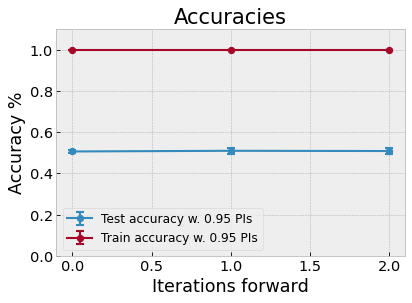

Test accuracies: [0.506215  0.5093722 0.5082378]
Confusion matrices:


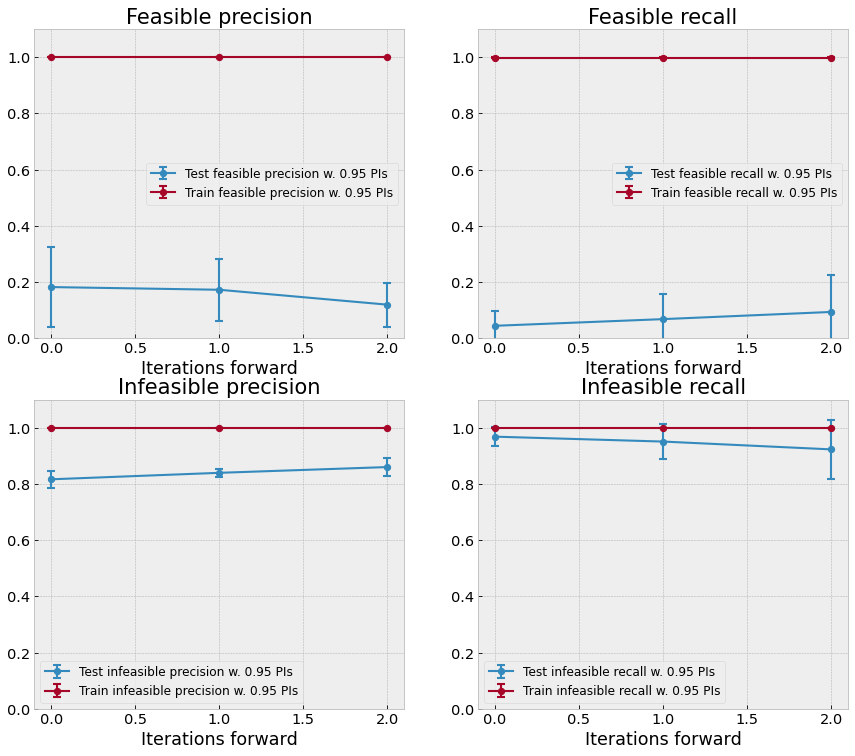

Percentage infeasible on test and train data:


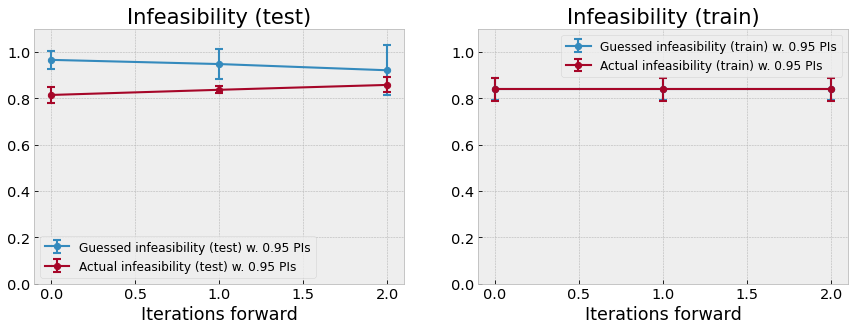

AUC:


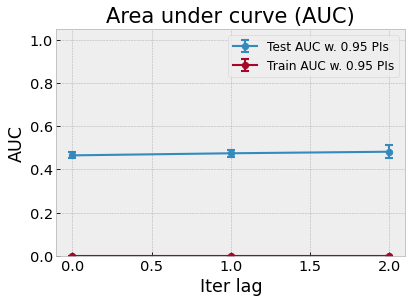

In [18]:
mt.plot_graphs()

## Conclusion

After hyperparameter tuning targeting reduction of overfitting and improved overall performance, we conclude: 

With **95%** confidene that the gradient boosting machine algorithm was **not** able to achieve performance any different than classifying the samples by flipping a coin.